<a href="https://colab.research.google.com/github/ShumailaAhmed/AI-Workshop/blob/main/Deep_Neural_Networks_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install pillow==4.0.0

     |████████████████████████████████| 5.6MB 9.0MB/s 
     |████████████████████████████████| 112kB 50.3MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=1ce1da12861c66a4fa3dcec93d43847fa188a7582396674528216d01941148ed
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: torchvision 0.8.1+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
#!pip3 install torch torchvision

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms 


In [2]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)
print(training_dataset)
print(validation_dataset)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

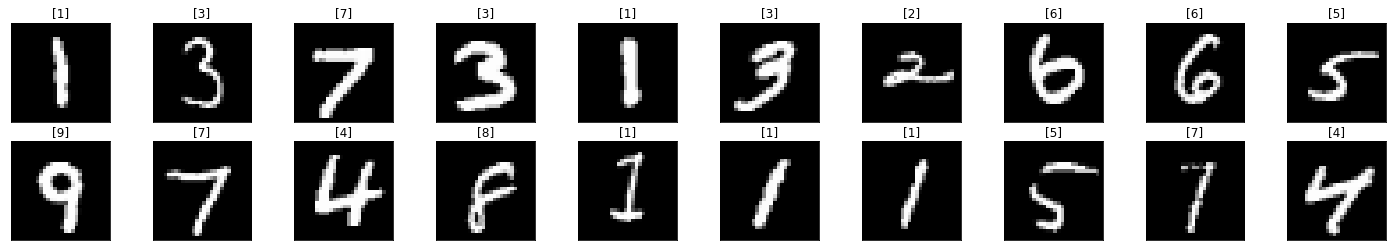

In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  

In [5]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [6]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [8]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9743, acc 76.2317 
validation loss: 0.4231, validation acc 89.2500 
epoch : 2
training loss: 0.3776, acc 89.5317 
validation loss: 0.3206, validation acc 90.6700 
epoch : 3
training loss: 0.3132, acc 90.9233 
validation loss: 0.2777, validation acc 92.1100 
epoch : 4
training loss: 0.2788, acc 91.8650 
validation loss: 0.2568, validation acc 92.6600 
epoch : 5
training loss: 0.2517, acc 92.7367 
validation loss: 0.2345, validation acc 93.3300 
epoch : 6
training loss: 0.2295, acc 93.4317 
validation loss: 0.2152, validation acc 93.6700 
epoch : 7
training loss: 0.2122, acc 93.9200 
validation loss: 0.1980, validation acc 94.3900 
epoch : 8
training loss: 0.1967, acc 94.3800 
validation loss: 0.1876, validation acc 94.5800 
epoch : 9
training loss: 0.1841, acc 94.7100 
validation loss: 0.1730, validation acc 94.9200 
epoch : 10
training loss: 0.1725, acc 95.0233 
validation loss: 0.1636, validation acc 95.2300 
epoch : 11
training loss: 0.1625, acc 95.3000 
va

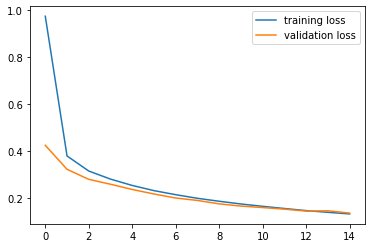

In [9]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

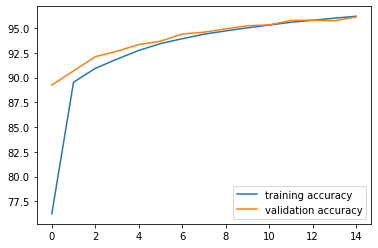

In [10]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [11]:
import PIL.ImageOps

In [16]:
!pip show pillow

Name: Pillow
Version: 7.0.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: wordcloud, torchvision, scikit-image, lucid, imgaug, imageio, image, fastai, bokeh


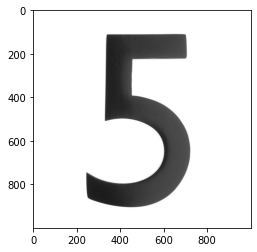

In [17]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

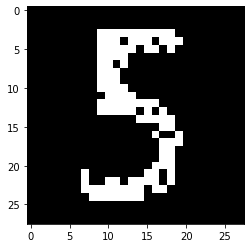

In [18]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [19]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


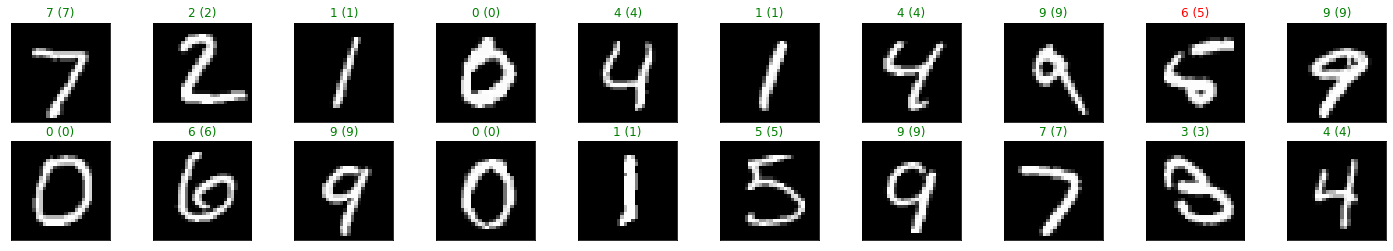

In [20]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))